# Code for CUQIpy paper 2, section 2. Framework for PDE-based Bayesian inverse problems in CUQIpy (sections 2.2 to 2.6)

##  2.2 The discretized heat equation in CUQIpy

Import the required libraries, modules and classes:

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous1D, KLExpansion, StepExpansion
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
from cuqi.sampler import CWMH
from cuqi.array import CUQIarray
from paper_figures import plot_figure2, plot_figure3, plot_figure4


Set the random seed for reproducibility:

In [42]:
# Set the random seed
np.random.seed(10)


Set the number of grid points and grid spacing:

In [43]:
n_grid = 100   # Number of solution nodes
h = 1/(n_grid+1)   # Space step size


Create the grid:

In [44]:
grid = np.linspace(h, 1-h, n_grid)


Set up the time discretization parameters:

In [45]:
tau_max = 0.01 # Final time
cfl = 5/11 # The cfl condition to have a stable solution
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps


Set up array `tau` of discretization times:

In [46]:
tau = np.linspace(0, tau_max, n_tau)


Set $c$ for thermal conductivity $c^2$:

In [47]:
c = 1


Create the source term `f` and the differential operator `D_c`:

In [48]:
f = np.zeros(n_grid)
D_c = c**2 * ( np.diag(-2*np.ones(n_grid), 0) +
np.diag(np.ones(n_grid-1), -1) +
np.diag(np.ones(n_grid-1), 1) ) / h**2


Create the PDE form:

In [49]:
def PDE_form(g, tau_current):
    return (D_c, f, g)


Create the `cuqi` PDE object:

In [50]:
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid)


In [51]:
print(PDE)


CUQI TimeDependentLinearPDE.
PDE form expression:
def PDE_form(g, tau_current):
    return (D_c, f, g)



Set up an initial condition `g_custom`:

In [52]:
g_custom =1/30*(1-np.cos(2*np.pi*(1-grid)/(1)))\
                +1/30*np.exp(-2*(10*(grid-0.5))**2)+\
                 1/30*np.exp(-2*(10*(grid-0.8))**2)


Assemble and solve the PDE given the initial condition `g_custom`:

In [53]:
PDE.assemble(g_custom)
u_custom, info = PDE.solve()


Apply the observation operator:

In [54]:
y_custom = PDE.observe(u_custom)


Code cell for plotting figure 2:

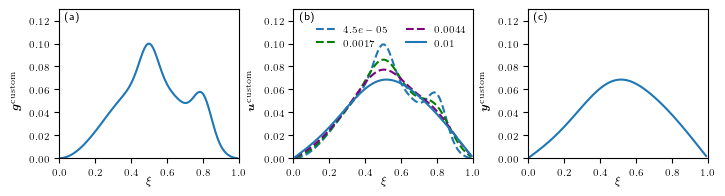

In [55]:
fig_dir = './figs/'
version = 'v3'

intermediate_indices = [1, 39, 99, len(tau)-1] # Indices of the intermediate times
intermediate_times = [tau[i] for i in intermediate_indices]
u_intermediate = u_custom[:, intermediate_indices] # Intermediate solutions

plot_figure2(fig_dir, version,
             g_custom, u_custom, y_custom, u_intermediate,
             grid, tau, intermediate_times)


## 2.3 The 1D heat forward problem in CUQIpy

Create a continuous geometry on the grid:

In [56]:
G_cont = Continuous1D(grid)


Create the `cuqi` forward model object:

In [57]:
A = PDEModel(PDE, range_geometry=G_cont, domain_geometry=G_cont)


## 2.4 Parametrization by the geometry class

The following code cell is to update final time to 0.02

In [58]:
tau_max = 0.02 # Final time
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int(tau_max/dt_approx)+1 # Number of time steps
tau = np.linspace(0, tau_max, n_tau)
PDE = TimeDependentLinearPDE(PDE_form, tau, grid_sol=grid)


Number of steps to be used in the step expansion parameterization:

In [59]:
n_step = 3


Create the step expansion geometry to represent the domain of the forward model:

In [60]:
G_step = StepExpansion(grid, n_steps=n_step)


Set up a `CUQIarray` that is interpreted by the step expansion geometry:

In [61]:
x_step = CUQIarray([0, 1, 0.5], geometry=G_step)


Plot the function representation of `x_step`:

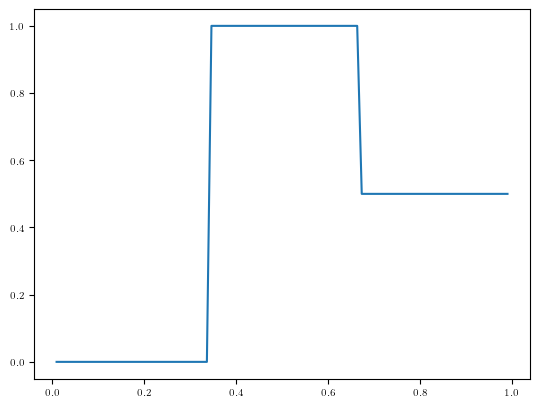

In [62]:
x_step.plot()


Plot the parameter representation of `x_step`:

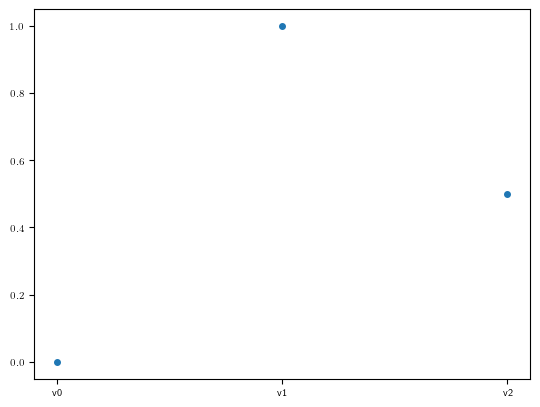

In [63]:
x_step.plot(plot_par=True)


Create a forward model with the step expansion geometry being the domain geometry:

In [64]:
A = PDEModel(PDE, range_geometry=G_cont, domain_geometry=G_step)


In [65]:
print(A)


CUQI PDEModel: StepExpansion(3,) -> Continuous1D(100,).
    Forward parameters: ['x'].
    PDE: TimeDependentLinearPDE.


Apply the forward model to get the exact data `y_step` and plot:

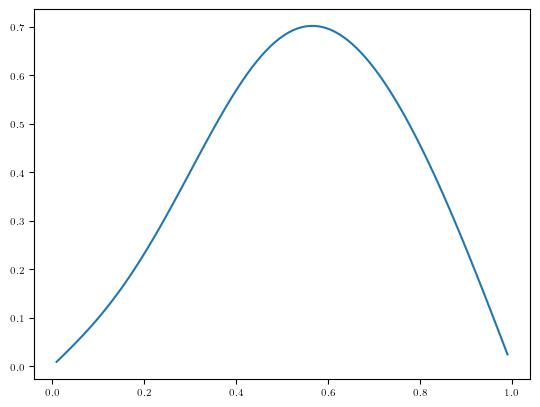

In [66]:
y_step = A(x=x_step)
y_step.plot()


Code cell for plotting figure 3:

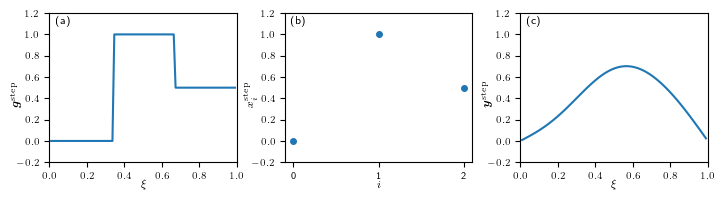

In [67]:
fig_dir = './figs/'
version = 'v3'
plot_figure3(fig_dir, version, x_step, y_step)


## 2.5. Specifying and solving the PDE-based Bayesian inverse problem

Set up the noise level:

In [68]:
# set up the noise level:
noise_level = 0.1
s_noise =1.0/np.sqrt(n_grid)* noise_level*np.linalg.norm(y_step)


Create the prior and the data distributions:

In [69]:
x = Gaussian(np.zeros(n_step), 1, geometry=G_step)
y = Gaussian(A(x), s_noise**2, geometry=G_cont)


In [70]:
print(y)


CUQI Gaussian. Conditioning variables ['x'].


Sample the prior:

In [71]:
prior_samples = x.sample(5)


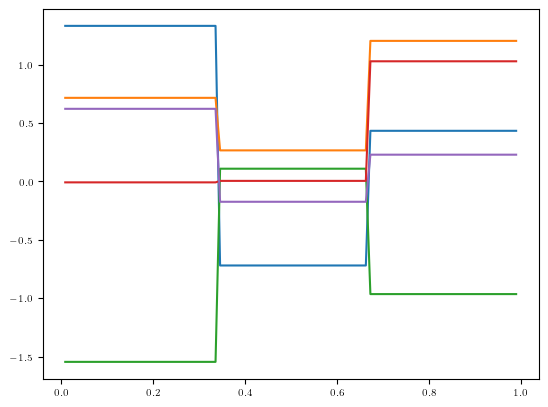

In [72]:
prior_samples.plot()


Obtain a realization of the noisy data by sampling the data distribution conditioned on `x=x_step`:

In [73]:
y_obs = y(x=x_step).sample()


Create a joint distribution of the prior and the data distribution, and obtain the posterior from it:

In [74]:
joint = JointDistribution(x, y)
posterior = joint(y=y_obs) # condition on y=y_obs


In [75]:
print(joint)


JointDistribution(
    Equation: 
	p(x,y) = p(x)p(y|x)
    Densities: 
	x ~ CUQI Gaussian.
	y ~ CUQI Gaussian. Conditioning variables ['x'].
)


Create a component-wise Metropolis Hastings sampler `CWMH` for the posterior:

In [76]:
my_sampler = CWMH(posterior)


Sample the posterior:

In [77]:
posterior_samples = my_sampler.sample_adapt(50000)


Sample 50000 / 50000

Average acceptance rate all components: 0.047606666666666665 



## 2.6. Posterior samples analysis, and visualization

Plot selected samples:

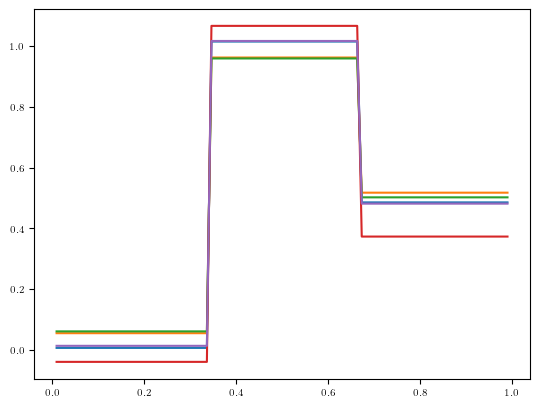

In [78]:
samples_indices = [2000, 3000, 4000, 5000, 6000]
posterior_samples.plot(samples_indices)


Plot the $95\%$ credible interval:

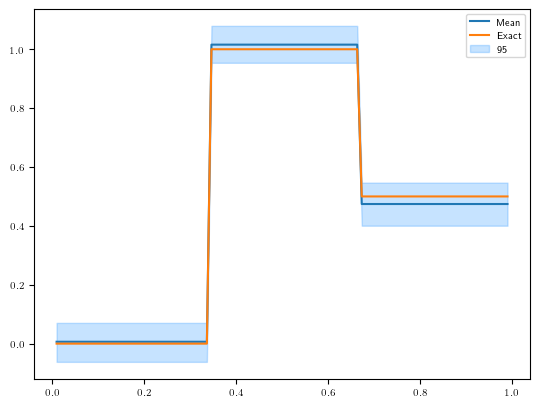

In [79]:
posterior_samples.plot_ci(95, exact=x_step)


Code cell for plotting figure 4:

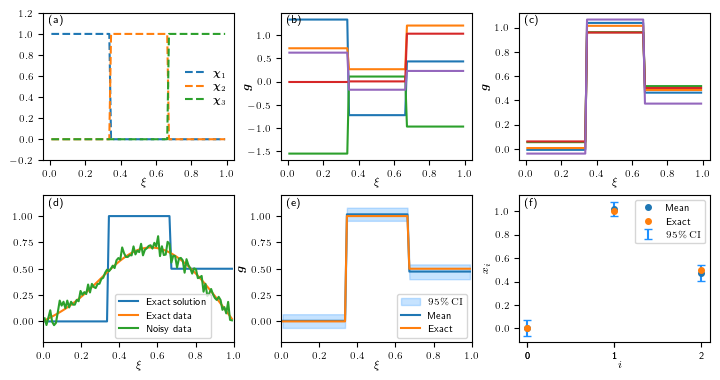

In [80]:
fig_dir = './figs/'
version = 'v6'
plot_figure4(fig_dir, version, G_step, 
                 prior_samples, posterior_samples,
                 x_step, y_step, y_obs)
